# 线性回归
- 优点：结果易于理解，计算不复杂
- 缺点：对非线性数据拟合不好
- 使用数据类型：数值型和标称型数据
 
预测结果$y_i = X^T_iw $ ,均方误差为 $\sum^m_{i=1}(y_i-x_i^Tw)^2$,也可以表示成矩阵的形式$(Y-XW)^T(Y-XW)$求导得$X^T(Y-XW)$，令其为0得
$$
\hat{w} = (X^TX)^{-1}X^Ty
$$
值得注意的是，上述公式包含$(X^TX)^{-1}$,也就是需要对矩阵求逆，因此这个方程只在逆矩阵存在时可用，然而**矩阵的逆可能不存在**
求解最佳w是统计学常见的问题，除了矩阵方法之外还有很多方法，通过调用NumPy里的矩阵方法，我们仅用几行代码就能完成功能，该方法也叫作ordinary least squares

In [1]:
import numpy as np
# 读取数据
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))-1
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [2]:
def standRegres(xArr,yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0:
        print('This matrix is singular, cannot do inverse')
        return 
    ws = xTx.I * (xMat.T * yMat)
    return ws

In [3]:
xArr,yArr = loadDataSet('../data/LinearRegression/ex0.txt')
xArr[0:2]

[[1.0, 0.067732], [1.0, 0.42781]]

In [4]:
ws = standRegres(xArr,yArr)

In [5]:
ws

matrix([[3.00774324],
        [1.69532264]])

In [6]:
xMat = np.mat(xArr)
yMat = np.mat(yArr)
yHat = xMat*ws

In [7]:
import matplotlib.pyplot as plt

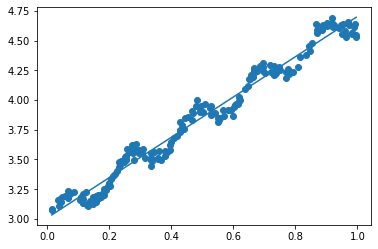

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
# 绘制散点
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0])

# 绘制回归线
xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy*ws
ax.plot(xCopy[:,1],yHat)
plt.show()
plt.close()

对于不同的数据集拟合成了完全一致的曲线可以通过实际值和预测值的相关系数来判断二者的匹配程度

In [9]:
yHat = xMat*ws
np.corrcoef(yHat.T,yMat)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

# 局部加权线性回归
- 线性回归可能出现欠拟合现象，因为其所求是具有均方误差的无偏估计
- LWLR(Locally Weighted Linear Regression)给带预测点附近的每个点赋一个权重，然后在这个子集上基于最小均方差进行回归
- 与knn一样，这种算法每次预测均需要先选出对应的数据子集,回归系数$\hat w=(X^TWX)^{-1}X^TWy$,$W$是一个矩阵，用来给每个数据点赋权重
- LWLR使用kernel来对附近的点赋予更高的权重$W$。核的类型可以自由选择，最常见的就是高斯核$w(i,j)=exp(\frac{|x^i-x|}{-2k^2})$
- 如此构建了一个只含对角元素的权重矩阵w，并且点x与x(i)越近，w(i,i)将会越大。上述核只需要用户指定一个k，他决定对附近点赋予多大权重，这也是LWLR唯一需要考虑的参数


In [10]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye(m))
    for j in range(m):
        diffMat = testPoint-xMat[j,:]
        weights[j,j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights*xMat)
    if np.linalg.det(xTx) == 0.0:
        print('This matrix is singular, cannot do inverse!')
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint*ws

In [11]:
def lwlrTest(testArr,xArr,yArr,k=1.0):
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

In [12]:
yArr[0]

3.176513

In [13]:
lwlr(xArr[0],xArr,yArr,1.0)

matrix([[3.12204471]])

In [14]:
lwlr(xArr[0],xArr,yArr,0.001)

matrix([[3.20175729]])

---
获取所有点的估计和原始值，看看拟合效果。
- k=1.0时权重很大，如同将所有数据视为等权重，得出的最佳拟合直线与标准回归一致
- k=0.01得到了不错的效果抓到了数据潜在特征
- k=0.003则纳入过多的噪声点，拟合的直线与训练数据过于接近，发生了过拟合

In [15]:
def plotTest(xArr,yArr,k):
    # 获取所有点预测值
    yHat = lwlrTest(xArr,xArr,yArr,k)

    # 对x进行排序
    xMat = np.mat(xArr)
    srtInd = xMat[:,1].argsort(0)
    xSort = xMat[srtInd][:,0,:]

    # 绘图
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xSort[:,1],yHat[srtInd])
    ax.scatter(xMat[:,1].flatten().A[0],np.mat(yArr).T.flatten().A[0],s=2,c='red')
    plt.title('k == ' + str(k))
    plt.show()

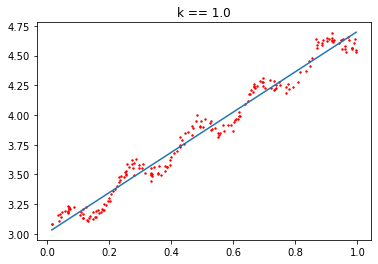

In [16]:
plotTest(xArr,yArr,1.0)

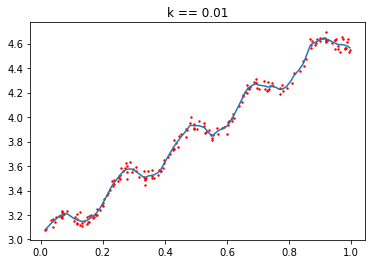

In [17]:
plotTest(xArr,yArr,0.01)

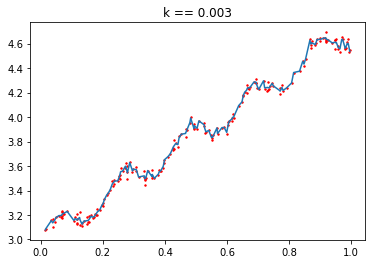

In [18]:
plotTest(xArr,yArr,0.003)

---
- 局部加权线性回归也存在问题，增加了计算量，对每个点做预测都必须使用整个数据集
- 观察k=0.01的情况就会发现大多数数据点权重接近0.避免这些计算就可以减少运行时间，缓解计算量带来的问题

## 预测鲍鱼年龄

In [19]:
def rssError(yArr,yHatArr):
    return ((yArr-yHatArr)**2).sum()

abX,abY = loadDataSet('../data/LinearRegression/abalone.txt')
yHat01 = lwlrTest(abX[0:99],abX[0:99],abY[0:99],0.1)
yHat1 = lwlrTest(abX[0:99],abX[0:99],abY[0:99],1)
yHat10 = lwlrTest(abX[0:99],abX[0:99],abY[0:99],10)

In [20]:
rssError(abY[0:99],yHat01.T)

56.78420911837208

In [21]:
rssError(abY[0:99],yHat1.T)

429.89056187030394

In [22]:
rssError(abY[0:99],yHat10.T)

549.1181708826065

---
显然较小的核通常会得到更低的误差，但是使用最小的核可能会过拟合，对新数据效果差

In [23]:
yHat01 = lwlrTest(abX[100:199],abX[0:99],abY[0:99],0.1)
rssError(abY[100:199],yHat01.T)

25119.459111157415

In [24]:
yHat1 = lwlrTest(abX[100:199],abX[0:99],abY[0:99],1)
rssError(abY[100:199],yHat1.T)

573.5261441895706

In [25]:
yHat10 = lwlrTest(abX[100:199],abX[0:99],abY[0:99],10)
rssError(abY[100:199],yHat10.T)

517.5711905381745

---
- 显然核大小为10时候测试误差最小，但是其在训练集上误差最大
- 下面是标准线性回归的结果,显然线性回归获得了与局部加权线性回归相似的效果，这也表明最佳核大小需要测试
- 局部加权线性回归每次必须在整个数据集上运行，就必须保存大量数据，这是一大缺陷

In [26]:
ws = standRegres(abX[0:99],abY[0:99])
yHat = np.mat(abX[100:199])*ws
rssError(abY[100:199],yHat.T.A)

518.6363153249081

# 缩减系数来“理解”数据
- 如果数据特征比样本数多，则不能使用之前的线性回归，因为计算$(X^TX)^{-1}$会出错，如果特征比样本点多，也就是输入数据矩阵$X$不是满秩的，非满秩矩阵求逆会出错
    - 统计学家引入**岭回归（ridge regression）**,这是一种缩减方法
    - **Lasso法**效果很好但计算复杂
    - **前向逐步回归** 可以得到与lasso差不多的效果，且更容易实现

## 岭回归
岭回归就是在矩阵$X^TX$上加上一个$\lambda I$从而使得矩阵非奇异，进而能对$X^TX+\lambda I$求逆，如此回归系数变成了
$$
    \hat{w} = (X^TX+\lambda I)^{-1}X^Ty
$$
岭回归最先用来处理特征数多余样本的情况，现在也用于在估计中加入偏差从而得到更好的估计，这里通过引入$\lambda$限制所有$w$之和,通过引入该惩罚项，能减少不重要的参数，这个技术在统计学中称为shrinkage

- 缩减方法可以去掉不重要参数，因此能更好的理解数据。此外，与简单线性回归相比缩减法能取得更好效果
- 与训练其他参数的方法类似，这里通过误差最小化得到$\lambda$,获得数据之后，首先抽一部分数据用于测试，剩余的作为训练集用于训练参数$w$，随后则在测试集上预测性能。通过选取不同的$\lambda$重复上述过程最终得到一个预测误差最小的$\lambda$

In [27]:
# 岭回归计算回归系数
def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0:
        print('This matrix is singular, cannot do inverse')
        return 
    ws = denom.I * (xMat.T*yMat)
    return ws

# 在一组lambda上测试结果
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean    
    xMeans = np.mean(xMat,0)
    xVar = np.var(xMat,0)
    xMat = (xMat-xMeans)/xVar
    
    numTestPts = 30
    wMat = np.zeros((numTestPts,np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))
        wMat[i,:] = ws.T
    return wMat

In [28]:
abX,abY = loadDataSet('../data/LinearRegression/abalone.txt')
ridgeWeights = ridgeTest(abX,abY)
ridgeWeights.shape

(30, 8)

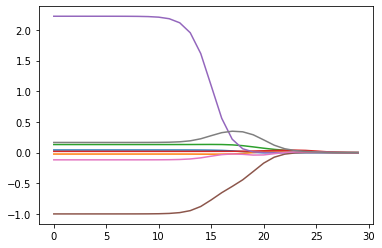

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.show()

## Lasso
不难证明，在增加如下约束时，普通最小二乘法回归得到与岭回归一样的公式
$$
    \sum^n_{k=1}{w^2_k}\leq \lambda
$$
上式限定了所有回归系数的平方和不能大于$\lambda$，使用普通的最小二乘回归在当两个或更多特征相关时，可能得出一个很大的正系数和负系数。正是因为上述限制条件的存在，使用岭回归可以避免这个问题

与岭回归类似，另一个缩减方法lasso也对回归系数做了限定，对应条件如下
$$
    \sum^n_{k=1}{|w_k|}\leq \lambda
$$
显然这里不同在于约束条件用绝对值取代平方和。$\lambda$足够小时，一些系数会因此被迫减到0，这个特性帮助我们更好的理解数据。这种细微的变化缺极大增加了计算复杂度，实际上有一种更简单的方法得到结构，称为**前向逐步回归**


## 前向逐步回归
前向逐步回归算法可以得到与lasso接近的效果，他是一种贪心算法，每一步都尽可能减小误差，一开始所有权重都设置为1，然后每一步做的决策是对某个权重增加或减少一个很小的值

伪代码如下
```
    数据标准化，使其满足0均值和单位方差
    每轮迭代过程中：
            设置当前最小误差lowestError为正无穷
            对每个特征：
                    增大或缩小：
                            改变一个系数得到一个新的w
                            计算新w下的误差
                            如果误差error小于当前最小lowerError;设置wbest等于当前w
                    将w设置为新的wbest
```

In [30]:
def regularize(xMat):
    inMat = xMat.copy()
    inMeans = np.mean(inMat,0)   
    inVar = np.var(inMat,0)   
    inMat = (inMat - inMeans)/inVar
    return inMat

def stageWise(xArr,yArr,eps=0.01,numIt=100):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean
    xMat = regularize(xMat)
    
    m,n = np.shape(xMat)
    returnMat = np.zeros((numIt,n))
    ws = np.zeros((n,1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    
    for i in range(numIt):
        # print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = rssError(yMat.A,yTest.A)
                if rssE <lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:] = ws.T
    return returnMat

In [31]:
xArr,yArr = loadDataSet('../data/LinearRegression/abalone.txt')
stageWise(xArr,yArr,0.01,200)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [32]:
stageWise(xArr,yArr,0.001,5000)

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])

将结果和最小二乘法进行比较

In [33]:
xMat = np.mat(xArr)
yMat = np.mat(yArr).T
xMat = regularize(xMat)
yM = np.mean(yMat,0)
yMat = yMat-yM
weights = standRegres(xMat,yMat.T)
weights.T

matrix([[ 0.0430442 , -0.02274163,  0.13214087,  0.02075182,  2.22403814,
         -0.99895312, -0.11725427,  0.16622915]])

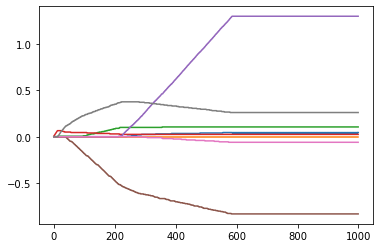

In [34]:
forwardStepWeights = stageWise(xArr,yArr,0.005,1000)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(forwardStepWeights)
plt.show()

- 逐步线性回归实际好处不在于绘制出上述的图，主要优点在于他可以帮助人们理解现有模型并做出改进。
- 构建一个模型后，可以运行该算法找出重要特征，这样就能及时停止收集不重要的特征数据
- 当应用缩减方法（逐步线性回归或岭回归）时，模型也就增加了bias,与此同时减少了variance
- 这也提供了一种潜在的挖掘大量数据内战在规律的方法，其可以指出哪些特征是关键的，那些特征不重要